## Description
__________

This script reads a selected ESP output file and produces a plot containing each ensemble member,  
uncertainty bands and the mean of the ensemble for a given variable. If simulated flow is being plotted,  
observed flow will also be plotted and simulated streamflow from a full model run can optionally be included. 


### Import Libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

### Inputs

In [2]:
esp_path = '../project/58418_esp_results/2011_esp.nc'   # Define the path to the ESP output to visualize
variable= 'cout'                                # Define the variable to plot (cout or snow)
output_directory= '../'                         # Define the location of the output

In [3]:
# adding computed runoff for given year (optional, replace with False if not using)
computed_path= '../0058418.txt'

### Plot ESP

In [4]:
# Open esp dataset
esp= xr.open_dataset(esp_path)

In [5]:
# Convert all data variable values to float
esp = esp.astype(float)

# Convert 'DATE' coordinate to datetime format
esp['DATE'] = pd.to_datetime(esp['DATE'])

In [6]:
# Extract the first and last date from the 'DATE' coordinate
first_date = esp['DATE'].min().values
last_date = esp['DATE'].max().values

# Format first and last dates to remove the time part
first_date_str = pd.Timestamp(first_date).strftime('%Y-%m-%d')
last_date_str = pd.Timestamp(last_date).strftime('%Y-%m-%d')

# Convert formatted date strings back to datetime objects
first_date_dt = pd.to_datetime(first_date_str, format='%Y-%m-%d')
last_date_dt = pd.to_datetime(last_date_str, format='%Y-%m-%d')

In [7]:
# Assuming 'DATE' is a coordinate in your xarray DataArray 'esp'
first_year = first_date_dt.year
esp = esp.where(esp['DATE'] >= pd.Timestamp(f"{first_year}-10-01"), drop=True)

In [8]:
# Calculate the mean of variable across ensemble members
mean_var = esp[variable].mean(dim='ensemble_member')

In [9]:
percentile_25 = esp[variable].quantile(0.25, dim='ensemble_member')
percentile_75 = esp[variable].quantile(0.75, dim='ensemble_member')

In [10]:
if computed_path is not None:
    # Read the DataFrame from the computed_path
    sim = pd.read_csv(computed_path, sep='\t', index_col=0)

    sim = sim.drop('UNITS', axis=0)

    # Convert index to datetime format
    sim.index = pd.to_datetime(sim.index, errors='coerce')

    # Trim the DataFrame based on the date range
    sim = sim.loc[pd.Timestamp(f"{first_year}-10-01"):last_date_dt]

    # Convert 'cout' column to numeric if needed
    sim['cout'] = pd.to_numeric(sim['cout'], errors='coerce')

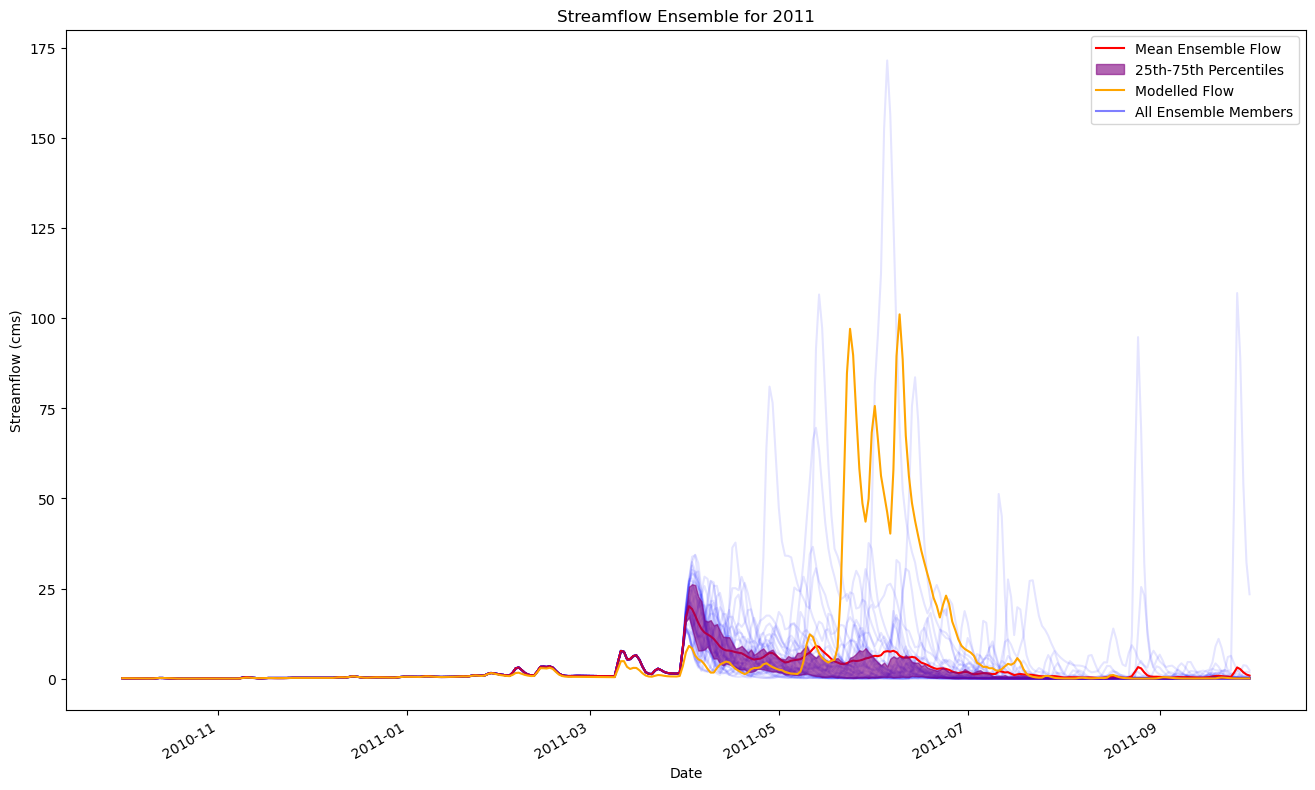

In [12]:
# Plotting all values of cout for each ensemble member
plt.figure(figsize=(16, 10))  # Adjust the figsize as needed
# Plot ensemble members with same color
esp[variable].plot.line(x='DATE', color='blue', alpha=0.1, zorder=1)
# Plot the mean value of 'cout' with a different style
mean_var.plot.line(x='DATE', color='red', label='Mean Ensemble Flow', zorder=2)
# Plot the 25th and 75th percentiles
plt.fill_between(mean_var['DATE'], percentile_25, percentile_75, color='purple', alpha=0.6, label='25th-75th Percentiles', zorder=3)

# If variable is 'cout', calculate and plot the mean of 'rout'
#if variable == 'cout':
#    # Calculate the mean of 'rout' across ensemble members
#    mean_obs = esp['rout'].mean(dim='ensemble_member')
#    mean_obs.plot.line(x='DATE', color='green', label='Mean Rout (Observed)', zorder=2)
    
if computed_path is not None:
    # Plot 'cout' from trimmed_df
    sim['cout'].plot.line(x='DATE', color='orange', label='Modelled Flow', zorder=4)
    
# Adding labels and title
plt.xlabel('Date')
plt.ylabel(f'Streamflow (cms)')
plt.title(f'Streamflow Ensemble for 2011')

# Create custom legend entry for all ensemble members
plt.plot([], color='blue', alpha=0.5, label='All Ensemble Members')

# Save the plot to the specified directory
save_path = os.path.join(output_directory, 'esp_plot.png')
plt.savefig(save_path)

# Display the legend
plt.legend()

# Display the plot
plt.show()